# 1D CNN modeling

### 1. Load Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

train = pd.read_csv('../../data/prepared_train.csv')
test = pd.read_csv('../../data/prepared_test.csv')

### 2. Train, Validation, Test split

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

group = ['lane_count', 'road_rating', 'weight_restricted', 'maximum_speed_limit']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in split.split(train, train[group]):
    train_set = train.loc[train_index]
    val_set = train.loc[val_index]

### 3. Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_ = scaler.fit_transform(train_set.loc[:, train_set.columns != 'target'])
train_ = pd.DataFrame(train_, columns=train_set.columns.drop('target').values)
train_['target'] = train_set[['target']].values
train_set = train_
train_ = 0

val_ = scaler.transform(val_set.loc[:, val_set.columns != 'target'])
val_ = pd.DataFrame(val_, columns=val_set.columns.drop('target').values)
val_['target'] = val_set[['target']].values
val_set = val_
val_ = 0

test_ = scaler.transform(test)
test_ = pd.DataFrame(test_, columns=test.columns)
test = test_
test_ = 0

### 4. DataLoader

In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.X = torch.tensor(dataset.loc[:, dataset.columns != 'target'].values, dtype=torch.float32, device="cuda")
        self.y = torch.tensor(dataset.loc[:, dataset.columns == 'target'].values, dtype=torch.float32, device="cuda")
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
_train = CustomDataset(train_set)
_valid = CustomDataset(val_set)
_test = CustomDataset(test)

trainloader = DataLoader(_train, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
validloader = DataLoader(_valid, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
testloader = DataLoader(_test, batch_size=1, shuffle=False, num_workers=0)

### 5. Simple Neural network

In [6]:
class Model(nn.Module):
        def __init__(self, num_features, num_targets, hidden_size):
            super(Model, self).__init__()
            cha_1 = 256
            cha_2 = 512
            cha_3 = 512

            cha_1_reshape = int(hidden_size/cha_1)
            cha_po_1 = int(hidden_size/cha_1/2)
            cha_po_2 = int(hidden_size/cha_1/2/2) * cha_3

            self.cha_1 = cha_1
            self.cha_2 = cha_2
            self.cha_3 = cha_3
            self.cha_1_reshape = cha_1_reshape
            self.cha_po_1 = cha_po_1
            self.cha_po_2 = cha_po_2

            self.batch_norm1 = nn.BatchNorm1d(num_features)
            self.dropout1 = nn.Dropout(0.1)
            self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))

            self.batch_norm_c1 = nn.BatchNorm1d(cha_1)
            self.dropout_c1 = nn.Dropout(0.1)
            self.conv1 = nn.utils.weight_norm(nn.Conv1d(cha_1,cha_2, kernel_size = 5, stride = 1, padding=2,  bias=False),dim=None)

            self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size = cha_po_1)

            self.batch_norm_c2 = nn.BatchNorm1d(cha_2)
            self.dropout_c2 = nn.Dropout(0.1)
            self.conv2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

            self.batch_norm_c2_1 = nn.BatchNorm1d(cha_2)
            self.dropout_c2_1 = nn.Dropout(0.3)
            self.conv2_1 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_2, kernel_size = 3, stride = 1, padding=1, bias=True),dim=None)

            self.batch_norm_c2_2 = nn.BatchNorm1d(cha_2)
            self.dropout_c2_2 = nn.Dropout(0.2)
            self.conv2_2 = nn.utils.weight_norm(nn.Conv1d(cha_2,cha_3, kernel_size = 5, stride = 1, padding=2, bias=True),dim=None)

            self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

            self.flt = nn.Flatten()

            self.batch_norm3 = nn.BatchNorm1d(cha_po_2)
            self.dropout3 = nn.Dropout(0.2)
            self.dense3 = nn.utils.weight_norm(nn.Linear(cha_po_2, num_targets))

        def forward(self, x):

            x = self.batch_norm1(x)
            x = self.dropout1(x)
            x = F.celu(self.dense1(x), alpha=0.06)

            x = x.reshape(x.shape[0],self.cha_1,
                          self.cha_1_reshape)

            x = self.batch_norm_c1(x)
            x = self.dropout_c1(x)
            x = F.relu(self.conv1(x))

            x = self.ave_po_c1(x)

            x = self.batch_norm_c2(x)
            x = self.dropout_c2(x)
            x = F.relu(self.conv2(x))
            x_s = x

            x = self.batch_norm_c2_1(x)
            x = self.dropout_c2_1(x)
            x = F.relu(self.conv2_1(x))

            x = self.batch_norm_c2_2(x)
            x = self.dropout_c2_2(x)
            x = F.relu(self.conv2_2(x))
            x =  x * x_s

            x = self.max_po_c2(x)

            x = self.flt(x)

            x = self.batch_norm3(x)
            x = self.dropout3(x)
            x = self.dense3(x)

            return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(33, 1, 4096).to(device)
print(model)

Model(
  (batch_norm1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=33, out_features=4096, bias=True)
  (batch_norm_c1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c1): Dropout(p=0.1, inplace=False)
  (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (ave_po_c1): AdaptiveAvgPool1d(output_size=8)
  (batch_norm_c2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c2): Dropout(p=0.1, inplace=False)
  (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm_c2_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_c2_1): Dropout(p=0.3, inplace=False)
  (conv2_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (batch_norm_c2_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, a

### 6. Loss function & Optimizer

In [12]:
import torch.optim as optim

learning_rate = 0.001
momentum = 0.09

criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

### 7. Train

In [13]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

num_epochs = 10
dataloader = {
    'train': trainloader,
    'valid': validloader,
}

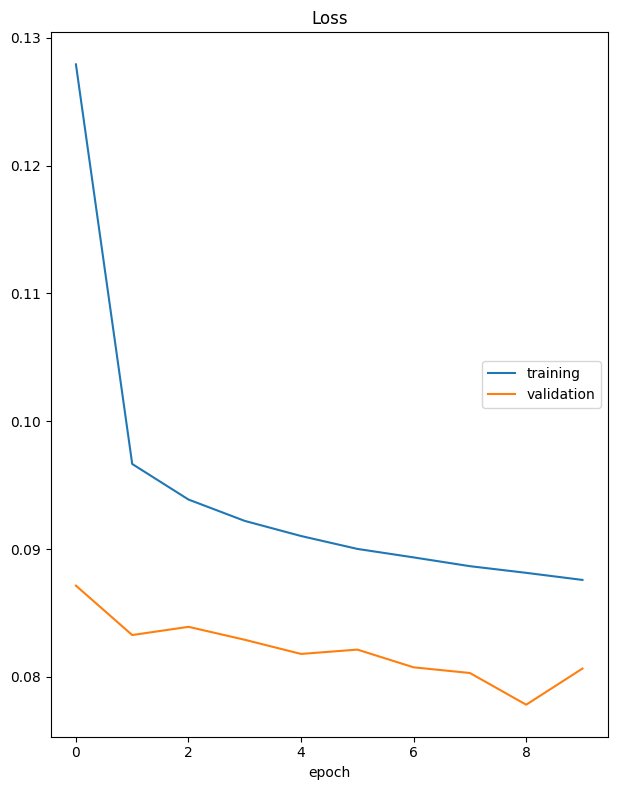

Loss
	training         	 (min:    0.088, max:    0.128, cur:    0.088)
	validation       	 (min:    0.078, max:    0.087, cur:    0.081)


In [14]:
liveloss = PlotLosses()

for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        accum_loss = 0
        cur_loss = 0
        for i, (data, labels) in enumerate(dataloader[phase]):
            inputs = data.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            cur_loss += loss.item()
            accum_loss += loss.item()
            
            if (phase == 'train') & (i % 5000 == 4999):
                print(f'[{epoch + 1}, {i + 1}] loss: {cur_loss / 5000:.3f}')
                cur_loss = 0
            elif (phase == 'valid') & (i % 2000 == 1999):
                print(f'[{epoch + 1}, {i + 1}] loss: {cur_loss / 2000:.3f}')
                cur_loss = 0                
                
        epoch_loss = accum_loss / len(dataloader[phase].dataset)
        
        prefix = ''
        if phase == 'valid':
            prefix = 'val_'
            
        logs[prefix + 'loss'] = epoch_loss

    liveloss.update(logs)
    liveloss.send()

### 8. Evaluation

In [15]:
model_path = '../../data/1D_CNN.pth'
torch.save(model.state_dict(), model_path)

model = Model(33, 1, 4096).to(device)
model.load_state_dict(torch.load(model_path))

submission = '../../data/sample_submission.csv'

results = pd.read_csv(submission)

In [16]:
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(testloader):
        inputs = data
        outputs = model(inputs)
        results.loc[i, ['target']] = outputs.cpu().detach().numpy()[0][0]

In [17]:
results.to_csv('../../data/sample_submission_1D_Conv.csv', index=False)